# Import libraries

In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from random import shuffle
import random

In [2]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Define constants & methods

In [3]:
%%javascript
var kernel = IPython.notebook.kernel;
var body = document.body,  
    attribs = body.attributes;
var command = "version_name = " + "'"+attribs['data-notebook-name'].value+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [4]:
version_name = version_name.split('.')[0]

In [5]:
save_model_path = "/home/chamodi17/Documents/fyp/notebooks/MobileNet/output/"+version_name
save_history_path = "/home/chamodi17/Documents/fyp/notebooks/MobileNet/output/"+version_name

In [6]:
save_history_path

'/home/chamodi17/Documents/fyp/notebooks/MobileNet/output/MobileNetV2-fine-tune_v9-k-cross'

In [7]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)

input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

In [8]:
# plot graphs for training and valdation data
def plot_graphs(history):
  acc = [0.] + history.history['accuracy']
  val_acc = [0.] + history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc,'o-g', label='Training Accuracy')
  plt.plot(val_acc, 'o-r',label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, 'o-g', label='Training Loss')
  plt.plot(val_loss, 'o-r',label='Validation Loss',color='red')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,3.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

In [22]:
# get accuray of test data
def getModelAccuracy(dataframe):
    sample_test = dataframe
    correctPredictions = 0

    correctNormalPred = 0
    correctCovidPred = 0
    correctPneumoniaPred = 0

    totalNormalPred = 0
    totalCovidPred = 0
    totalPneumoniaPred = 0

    for index, row in sample_test.iterrows():

        filename = row['filename']
        prediction = row['category']

        # img = load_img(path + 'CrossValidationDataset\\' + filename, target_size=IMAGE_SIZE)

        if (path +'/normal') in filename:

            if prediction == 0:
                correctPredictions += 1
                correctNormalPred += 1

            totalNormalPred += 1

        if (path + '/covid') in filename:

            if prediction == 1: 
                correctPredictions += 1
                correctCovidPred += 1

            totalCovidPred += 1

        if (path + '/pneumonia') in filename:

            if prediction == 2: 
                correctPredictions += 1
                correctPneumoniaPred += 1

            totalPneumoniaPred += 1
            
    print('Model Accuracy:', "{:.2%}".format(correctPredictions / test_df.shape[0]))
    print('Correct Predictions:', correctPredictions, 'Total Predictions:', test_df.shape[0])

    print('\nNormal Predictions:', correctNormalPred, 'Accuracy', "{:.2%}".format(correctNormalPred /  totalNormalPred))
    print('Covid Predictions:', correctCovidPred, 'Accuracy', "{:.2%}".format(correctCovidPred /  totalCovidPred))
    print('Pneumonia Predictions:', correctPneumoniaPred, 'Accuracy', "{:.2%}".format(correctPneumoniaPred / totalPneumoniaPred))
    
    return (correctPredictions / test_df.shape[0]) * 100

In [23]:
# plot confusion matrix
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import itertools

# np_config.enable_numpy_behavior()
    
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion Matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Oranges')

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    # thresh = np.max(cm) / 1.5 if normalize else np.max(cm) / 2

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    



In [24]:
path = "/home/sch17/Documents/fyp/dataset"

# Create dataframe

In [25]:
directories = ['/normal']
categories = []
filenames = []
    
files = os.listdir(path + directories[0])

for img in files:
    categories.append(0)
    filenames.append(path+directories[0]+"/"+img)

files.sort()
df_NORMAL = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

print(df_NORMAL.shape[0])
df_NORMAL.head()

directories = ['/pneumonia']
categories = []
filenames = []
    
files = os.listdir(path + directories[0])

for img in files:
    categories.append(2)
    filenames.append(path+directories[0]+"/"+img)

files.sort()
df_PNEUMONIA = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

print(df_PNEUMONIA.shape[0])
df_PNEUMONIA.head()

directories = ['/covid']
categories = []
filenames = []
    
files = os.listdir(path + directories[0])

for img in files:
    categories.append(1)
    filenames.append(path+directories[0]+"/"+img)

files.sort()
df_COVID = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

print(df_COVID.shape[0])
df_COVID.head()


1583
4273
3616


,filename,category
0,/home/sch17/Documents/fyp/dataset/covid/COVID-321.png,1
1,/home/sch17/Documents/fyp/dataset/covid/COVID-1605.png,1
2,/home/sch17/Documents/fyp/dataset/covid/COVID-1796.png,1
3,/home/sch17/Documents/fyp/dataset/covid/COVID-407.png,1
4,/home/sch17/Documents/fyp/dataset/covid/COVID-191.png,1


In [26]:
pd.options.display.max_colwidth = 100

In [27]:
df = pd.concat([df_NORMAL, df_PNEUMONIA, df_COVID])


In [28]:
# shuffle data
df = df.sample(frac=1).reset_index(drop = True)
df

,filename,category
0,/home/sch17/Documents/fyp/dataset/covid/COVID-2231.png,1
1,/home/sch17/Documents/fyp/dataset/covid/COVID-2806.png,1
2,/home/sch17/Documents/fyp/dataset/covid/COVID-1378.png,1
3,/home/sch17/Documents/fyp/dataset/covid/COVID-2121.png,1
4,/home/sch17/Documents/fyp/dataset/pneumonia/person111_virus_212.jpeg,2
...,...,...
9467,/home/sch17/Documents/fyp/dataset/pneumonia/person325_virus_660.jpeg,2
9468,/home/sch17/Documents/fyp/dataset/pneumonia/person292_virus_602.jpeg,2
9469,/home/sch17/Documents/fyp/dataset/pneumonia/person441_bacteria_1904.jpeg,2
9470,/home/sch17/Documents/fyp/dataset/pneumonia/person1070_virus_1773.jpeg,2


<AxesSubplot:>

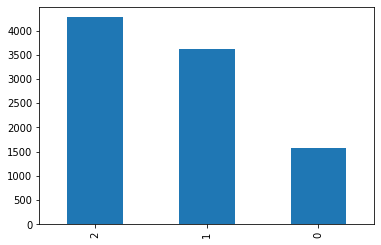

In [30]:
df['category'].value_counts().plot.bar()

train/val/test split - 60% | 20% | 20%

# Model






Transfer Learning

In [16]:
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')


In [17]:
base_model.trainable = False

In [18]:
inputs = tf.keras.Input(shape=input_shape)
x = base_model(inputs, training=False)
x = tfl.GlobalAveragePooling2D()(x)
x = tfl.Dropout(0.2)(x)
outputs = tfl.Dense(3, activation='softmax')(x) 
model = tf.keras.Model(inputs, outputs)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


# K cross

Found 5682 validated image filenames belonging to 3 classes.
Found 1895 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
178/178 [==============================] - 105s 575ms/step - loss: 0.9276 - accuracy: 0.5910 - val_loss: 0.4954 - val_accuracy: 0.8559
Epoch 2/10
178/178 [==============================] - 102s 571ms/step - loss: 0.4130 - accuracy: 0.8618 - val_loss: 0.2886 - val_accuracy: 0.9214
Epoch 3/10
178/178 [==============================] - 102s 571ms/step - loss: 0.2736 - accuracy: 0.9141 - val_loss: 0.2208 - val_accuracy: 0.9361
Epoch 4/10
178/178 [==============================] - 102s 571ms/step - loss: 0.2238 - accuracy: 0.9229 - val_loss: 0.1827 - val_accuracy: 0.9483
Epoch 5/10
178/178 [==============================] - 101s 566ms/step - loss: 0.1960 - accuracy: 0.9342 - val_loss: 0.1630 - val_accuracy: 0.9515
Epoch 6/10
178/178 [==============================]

178/178 [==============================] - 104s 581ms/step - loss: 0.0127 - accuracy: 0.9956 - val_loss: 0.0932 - val_accuracy: 0.9794

Epoch 00037: val_loss did not improve from 0.05350
Epoch 38/40
178/178 [==============================] - 104s 585ms/step - loss: 0.0134 - accuracy: 0.9952 - val_loss: 0.0869 - val_accuracy: 0.9805

Epoch 00038: val_loss did not improve from 0.05350
Epoch 39/40
178/178 [==============================] - 104s 584ms/step - loss: 0.0104 - accuracy: 0.9960 - val_loss: 0.0983 - val_accuracy: 0.9784

Epoch 00039: val_loss did not improve from 0.05350
Epoch 40/40
178/178 [==============================] - 104s 582ms/step - loss: 0.0087 - accuracy: 0.9963 - val_loss: 0.1106 - val_accuracy: 0.9789

Epoch 00040: val_loss did not improve from 0.05350


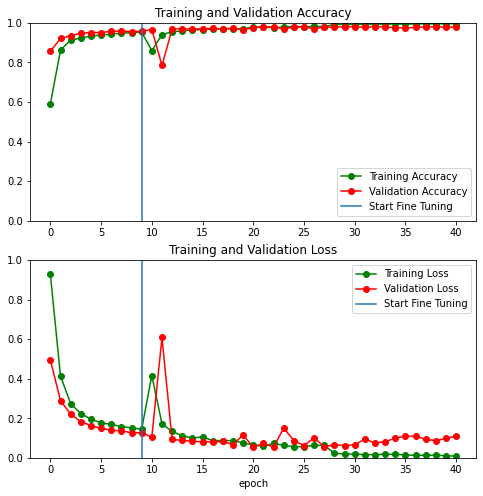

Found 1895 validated image filenames.
Model Accuracy: 98.15%
Correct Predictions: 1860 Total Predictions: 1895

Normal Predictions: 294 Accuracy 97.67%
Covid Predictions: 714 Accuracy 99.58%
Pneumonia Predictions: 852 Accuracy 97.15%


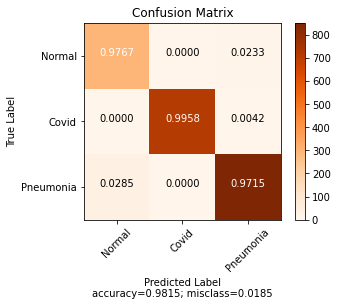

              precision    recall  f1-score   support

      Normal       0.92      0.98      0.95       301
       Covid       1.00      1.00      1.00       717
   Pneumonia       0.99      0.97      0.98       877

    accuracy                           0.98      1895
   macro avg       0.97      0.98      0.98      1895
weighted avg       0.98      0.98      0.98      1895

Precision: 0.9700097219898804
Recall: 0.9813512714161327
F1 : 0.9753880504090939
[[294   0   7]
 [  0 714   3]
 [ 25   0 852]]
Found 5682 validated image filenames belonging to 3 classes.
Found 1895 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/10
178/178 [==============================] - 105s 577ms/step - loss: 0.8352 - accuracy: 0.6323 - val_loss: 0.5338 - val_accuracy: 0.8026
Epoch 2/10
178/178 [==============================] - 101s 567ms/step - loss: 0.4029 - accuracy: 0.8634 - val_loss: 0.3145 - va

/home/chamodi17/.local/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/40
178/178 [==============================] - 104s 582ms/step - loss: 0.1672 - accuracy: 0.9432 - val_loss: 0.0962 - val_accuracy: 0.9699

Epoch 00011: val_loss improved from 0.20629 to 0.09620, saving model to /home/chamodi17/Documents/fyp/notebooks/MobileNet/output/MobileNetV2-fine-tune_v9-k-cross_2.h5
Epoch 12/40
178/178 [==============================] - 104s 580ms/step - loss: 0.1316 - accuracy: 0.9534 - val_loss: 0.0816 - val_accuracy: 0.9689

Epoch 00012: val_loss improved from 0.09620 to 0.08157, saving model to /home/chamodi17/Documents/fyp/notebooks/MobileNet/output/MobileNetV2-fine-tune_v9-k-cross_2.h5
Epoch 13/40
178/178 [==============================] - 104s 583ms/step - loss: 0.1142 - accuracy: 0.9620 - val_loss: 0.1672 - val_accuracy: 0.9309

Epoch 00013: val_loss did not improve from 0.08157
Epoch 14/40
178/178 [==============================] - 103s 579ms/step - loss: 0.1003 - accuracy: 0.9676 - val_loss: 0.0968 - val_accuracy: 0.9662

Epoch 00014: val_loss d

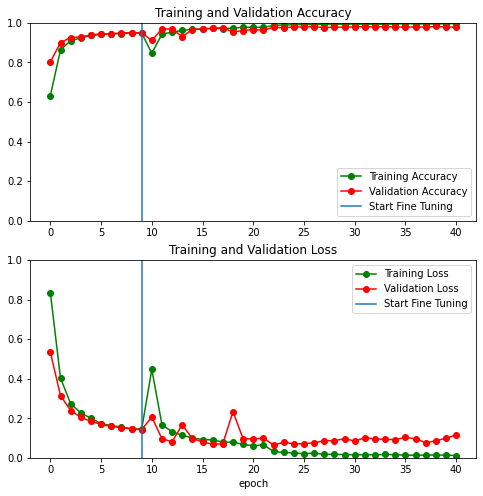

Found 1895 validated image filenames.
Model Accuracy: 97.73%
Correct Predictions: 1852 Total Predictions: 1895

Normal Predictions: 298 Accuracy 94.90%
Covid Predictions: 756 Accuracy 99.34%
Pneumonia Predictions: 798 Accuracy 97.32%


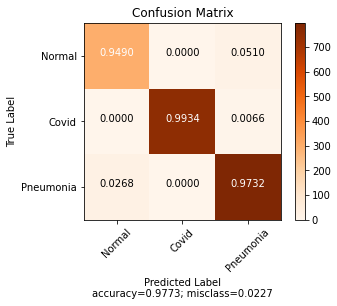

              precision    recall  f1-score   support

      Normal       0.93      0.95      0.94       314
       Covid       1.00      0.99      1.00       761
   Pneumonia       0.97      0.97      0.97       820

    accuracy                           0.98      1895
   macro avg       0.97      0.97      0.97      1895
weighted avg       0.98      0.98      0.98      1895

Precision: 0.9685363247863248
Recall: 0.9718816718202251
F1 : 0.9701772010399763
[[298   0  16]
 [  0 756   5]
 [ 22   0 798]]
Found 5683 validated image filenames belonging to 3 classes.
Found 1895 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/10
178/178 [==============================] - 106s 579ms/step - loss: 0.8164 - accuracy: 0.6482 - val_loss: 0.4742 - val_accuracy: 0.8464
Epoch 2/10
178/178 [==============================] - 102s 571ms/step - loss: 0.4043 - accuracy: 0.8578 - val_loss: 0.2915 - va

/home/chamodi17/.local/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/40
178/178 [==============================] - 104s 582ms/step - loss: 0.1695 - accuracy: 0.9400 - val_loss: 0.1022 - val_accuracy: 0.9609

Epoch 00011: val_loss improved from 0.32701 to 0.10217, saving model to /home/chamodi17/Documents/fyp/notebooks/MobileNet/output/MobileNetV2-fine-tune_v9-k-cross_3.h5
Epoch 12/40
178/178 [==============================] - 103s 578ms/step - loss: 0.1295 - accuracy: 0.9569 - val_loss: 0.1127 - val_accuracy: 0.9657

Epoch 00012: val_loss did not improve from 0.10217
Epoch 13/40
178/178 [==============================] - 104s 580ms/step - loss: 0.1113 - accuracy: 0.9616 - val_loss: 0.0963 - val_accuracy: 0.9678

Epoch 00013: val_loss improved from 0.10217 to 0.09633, saving model to /home/chamodi17/Documents/fyp/notebooks/MobileNet/output/MobileNetV2-fine-tune_v9-k-cross_3.h5
Epoch 14/40
178/178 [==============================] - 103s 578ms/step - loss: 0.1032 - accuracy: 0.9659 - val_loss: 0.1144 - val_accuracy: 0.9636

Epoch 00014: val_loss d

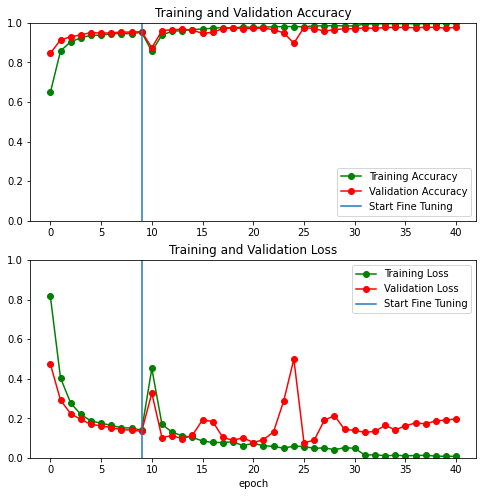

Found 1894 validated image filenames.
Model Accuracy: 98.42%
Correct Predictions: 1864 Total Predictions: 1894

Normal Predictions: 292 Accuracy 95.11%
Covid Predictions: 733 Accuracy 99.86%
Pneumonia Predictions: 839 Accuracy 98.36%


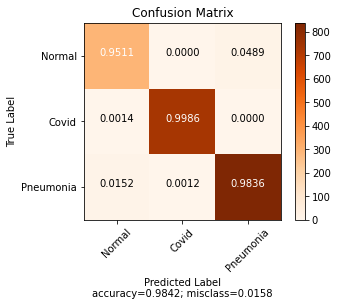

              precision    recall  f1-score   support

      Normal       0.95      0.95      0.95       307
       Covid       1.00      1.00      1.00       734
   Pneumonia       0.98      0.98      0.98       853

    accuracy                           0.98      1894
   macro avg       0.98      0.98      0.98      1894
weighted avg       0.98      0.98      0.98      1894

Precision: 0.9784405217942013
Recall: 0.9777883353768789
F1 : 0.9781134710264651
[[292   0  15]
 [  1 733   0]
 [ 13   1 839]]
Found 5683 validated image filenames belonging to 3 classes.
Found 1895 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/10
178/178 [==============================] - 105s 573ms/step - loss: 0.7434 - accuracy: 0.6727 - val_loss: 0.4678 - val_accuracy: 0.8306
Epoch 2/10
178/178 [==============================] - 101s 568ms/step - loss: 0.4001 - accuracy: 0.8571 - val_loss: 0.2900 - va

/home/chamodi17/.local/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/40
178/178 [==============================] - 103s 575ms/step - loss: 0.1842 - accuracy: 0.9351 - val_loss: 0.0850 - val_accuracy: 0.9699

Epoch 00011: val_loss improved from 0.11607 to 0.08496, saving model to /home/chamodi17/Documents/fyp/notebooks/MobileNet/output/MobileNetV2-fine-tune_v9-k-cross_4.h5
Epoch 12/40
178/178 [==============================] - 104s 582ms/step - loss: 0.1447 - accuracy: 0.9500 - val_loss: 0.2370 - val_accuracy: 0.9172

Epoch 00012: val_loss did not improve from 0.08496
Epoch 13/40
178/178 [==============================] - 104s 581ms/step - loss: 0.1099 - accuracy: 0.9597 - val_loss: 0.1006 - val_accuracy: 0.9615

Epoch 00013: val_loss did not improve from 0.08496
Epoch 14/40
178/178 [==============================] - 104s 581ms/step - loss: 0.1019 - accuracy: 0.9630 - val_loss: 0.0862 - val_accuracy: 0.9731

Epoch 00014: val_loss did not improve from 0.08496
Epoch 15/40
178/178 [==============================] - 104s 581ms/step - loss: 0.0930 - 

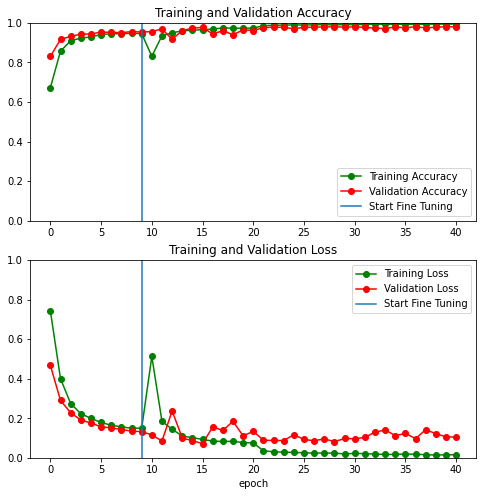

Found 1894 validated image filenames.
Model Accuracy: 97.57%
Correct Predictions: 1848 Total Predictions: 1894

Normal Predictions: 319 Accuracy 94.10%
Covid Predictions: 680 Accuracy 98.55%
Pneumonia Predictions: 849 Accuracy 98.15%


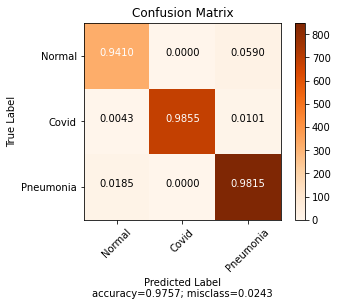

              precision    recall  f1-score   support

      Normal       0.94      0.94      0.94       339
       Covid       1.00      0.99      0.99       690
   Pneumonia       0.97      0.98      0.98       865

    accuracy                           0.98      1894
   macro avg       0.97      0.97      0.97      1894
weighted avg       0.98      0.98      0.98      1894

Precision: 0.9709883548134339
Recall: 0.9693376954675764
F1 : 0.9701317302188217
[[319   0  20]
 [  3 680   7]
 [ 16   0 849]]
Found 5683 validated image filenames belonging to 3 classes.
Found 1895 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/10
178/178 [==============================] - 104s 573ms/step - loss: 0.8540 - accuracy: 0.6136 - val_loss: 0.5145 - val_accuracy: 0.8121
Epoch 2/10
178/178 [==============================] - 101s 567ms/step - loss: 0.4229 - accuracy: 0.8459 - val_loss: 0.3002 - va

/home/chamodi17/.local/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/40
178/178 [==============================] - 103s 578ms/step - loss: 0.1726 - accuracy: 0.9416 - val_loss: 0.0912 - val_accuracy: 0.9668

Epoch 00011: val_loss improved from 0.21769 to 0.09118, saving model to /home/chamodi17/Documents/fyp/notebooks/MobileNet/output/MobileNetV2-fine-tune_v9-k-cross_5.h5
Epoch 12/40
178/178 [==============================] - 103s 576ms/step - loss: 0.1421 - accuracy: 0.9513 - val_loss: 0.1164 - val_accuracy: 0.9678

Epoch 00012: val_loss did not improve from 0.09118
Epoch 13/40
178/178 [==============================] - 103s 577ms/step - loss: 0.1214 - accuracy: 0.9608 - val_loss: 0.0637 - val_accuracy: 0.9763

Epoch 00013: val_loss improved from 0.09118 to 0.06370, saving model to /home/chamodi17/Documents/fyp/notebooks/MobileNet/output/MobileNetV2-fine-tune_v9-k-cross_5.h5
Epoch 14/40
178/178 [==============================] - 103s 579ms/step - loss: 0.1004 - accuracy: 0.9646 - val_loss: 0.0854 - val_accuracy: 0.9720

Epoch 00014: val_loss d

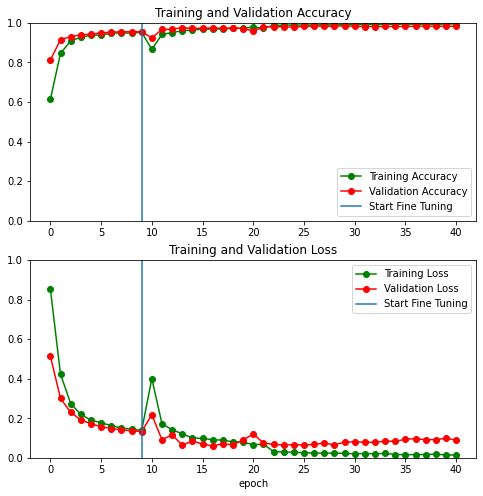

Found 1894 validated image filenames.
Model Accuracy: 97.62%
Correct Predictions: 1849 Total Predictions: 1894

Normal Predictions: 291 Accuracy 90.37%
Covid Predictions: 712 Accuracy 99.72%
Pneumonia Predictions: 846 Accuracy 98.60%


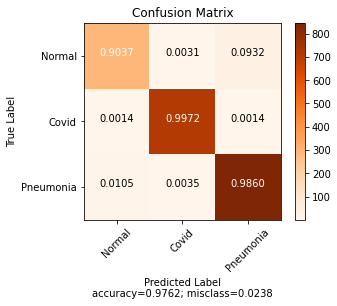

              precision    recall  f1-score   support

      Normal       0.97      0.90      0.93       322
       Covid       0.99      1.00      1.00       714
   Pneumonia       0.96      0.99      0.98       858

    accuracy                           0.98      1894
   macro avg       0.98      0.96      0.97      1894
weighted avg       0.98      0.98      0.98      1894

Precision: 0.9752810133160902
Recall: 0.9623131912134469
F1 : 0.9684032467440815
[[291   1  30]
 [  1 712   1]
 [  9   3 846]]
[98.15303430079155, 97.73087071240106, 98.41605068637803, 97.571277719113, 97.62407602956705]
average accuracy =  97.89906188965013


In [32]:
from sklearn.model_selection import KFold

fold_no = 1
batch_size = 32
initial_epochs = 10
fine_tune_epochs = 30
total_epochs = initial_epochs + fine_tune_epochs

acc_per_fold = []
perf_per_fold = []

inputs = df['filename']
targets = df['category']

# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

for train, test in kfold.split(inputs, targets):
  tf.keras.backend.clear_session()
  base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
  base_model.trainable = False
  input_tensor = tf.keras.Input(shape=input_shape)
  x = base_model(input_tensor, training=False)
  x = tfl.GlobalAveragePooling2D()(x)
  x = tfl.Dropout(0.2)(x)
  outputs = tfl.Dense(3, activation='softmax')(x) 
  model = tf.keras.Model(input_tensor, outputs)

  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate= 0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
  
  ##Separate Training Data
  categories = []
  
  for img in inputs[train]:

      fileName = img.split('.')[0]

      if '/normal' in fileName: categories.append(0)
      elif '/covid' in fileName: categories.append(1)
      else: categories.append(2)

  cross_val_df = pd.DataFrame ({
      'filename': inputs[train],
      'category': categories
  })

  cross_val_df["category"] = cross_val_df["category"].replace({0: 'Normal', 1: 'Covid', 2:'Pneumonia'})
    
  train_df, validate_df = train_test_split(cross_val_df, test_size=0.25)
  train_df = train_df.reset_index(drop=True)
  validate_df = validate_df.reset_index(drop=True)

  train_generator = ImageDataGenerator(
      rescale=1./127.5,
      width_shift_range = 0.1,
      height_shift_range = 0.1
      ).flow_from_dataframe (
        train_df, 
        x_col = 'filename',
        y_col = 'category',
        target_size = IMAGE_SIZE,
        class_mode = 'categorical',
        batch_size = batch_size
    )
  
  validation_generator = ImageDataGenerator(rescale=1./127.5).flow_from_dataframe (
        validate_df, 
        x_col ='filename',
        y_col = 'category',
        target_size = IMAGE_SIZE,
        class_mode = 'categorical',
        batch_size = batch_size
    )
  
  
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  
  model_checkpoint = ModelCheckpoint(save_model_path + '_' + str(fold_no) +".h5", save_best_only=True, verbose=1)
  reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

  history = model.fit(train_generator,
                    validation_data=validation_generator, 
                    epochs=initial_epochs,
                    batch_size=batch_size)
  
  base_model.trainable = True
  # Fine-tune from this layer onwards
  fine_tune_at = 100

  # Freeze all the layers before the `fine_tune_at` layer
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate= 0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
  
  history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_generator,
                         batch_size=batch_size,
                         callbacks=[model_checkpoint, reduce_lr])

  
  model.save(save_model_path + '_' + str(fold_no) +".h5") # save path

  ## plot graph
  # plot_graphs(history)
  acc = history.history['accuracy'] + history_fine.history['accuracy']
  val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

  loss = history.history['loss'] + history_fine.history['loss']
  val_loss = history.history['val_loss'] + history_fine.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, 'o-g', label='Training Accuracy')
  plt.plot(val_acc, 'o-r', label='Validation Accuracy')
  plt.ylim([0, 1])
  plt.plot([initial_epochs-1,initial_epochs-1],
            plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, 'o-g', label='Training Loss')
  plt.plot(val_loss, 'o-r', label='Validation Loss')
  plt.ylim([0, 1.0])
  plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

  ##Separate Testing Data
  test_filenames = []
    
  for img in inputs[test]:

      test_filenames.append(img)
      
  test_df = pd.DataFrame({
      'filename': test_filenames
  })
  
  nb_samples = test_df.shape[0]

  test_generator = ImageDataGenerator(rescale = 1./127.5).flow_from_dataframe(
      test_df, 
      x_col = 'filename',
      y_col = None,
      class_mode = None,
      target_size = IMAGE_SIZE,
      batch_size = batch_size,
      shuffle = False
  )

  #Get Test Data Predictions 
  predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

  # print("predict================================================================")
  # print(predict)
  # print("done================================================================")

  test_df['category'] = np.argmax(predict, axis=-1)
  label_map = dict((v,k) for k,v in train_generator.class_indices.items())
  test_df['category'] = test_df['category'].replace(label_map)
  test_df['category'] = test_df['category'].replace({'Normal': 0, 'Covid': 1, 'Pneumonia': 2})

  actual = []
  pred = []

  for row in test_df.iterrows():

      filename = row[1][0]

      if '/normal' in filename: actual.append(0)
      elif '/covid' in filename: actual.append(1)
      elif '/pneumonia' in filename: actual.append(2)
      pred.append(row[1][1])


  fold_no = fold_no + 1

  # Get performance metrics  
  accuracy = getModelAccuracy(test_df)
  acc_per_fold.append(accuracy)
  perf_per_fold.append([actual, pred])

  cf = confusion_matrix(actual, pred)

  # print("##############################printing cf#################################")
  # print(cf)
  # print(type(cf))
  # print("##############################done#################################")

    
  target_names = ['Normal','Covid', 'Pneumonia']
  plot_confusion_matrix(cf, target_names)

  print(classification_report(actual, pred, target_names=target_names))  
  # break
  # if(fold_no==4):
  #   break
  # calculate precision
  precision = precision_score(actual, pred,  average='macro')
  print('Precision:', precision)

  # calculate recall
  recall = recall_score(actual, pred,  average='macro')
  print('Recall:', recall)

  # f1
  # f1 =  2 * (precision * recall) / (precision + recall)
  f1 = f1_score(actual, pred,  average='macro')
  print ("F1 :", f1)

  print(confusion_matrix(actual, pred))
print(acc_per_fold)
print("average accuracy = ",sum(acc_per_fold)/5)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 1,865,283
Non-trainable params: 396,544
_________________________________________________________________


In [ ]:
model.evaluate(test_generator_eval)

60/60 [==============================] - 16s 270ms/step - loss: 0.0785 - accuracy: 0.9805


[0.0785280242562294, 0.9804749488830566]

# Saved model


In [ ]:
loaded_model = tf.keras.models.load_model(save_model_path)











































































































# predict

In [ ]:
pre_test_df = test_df

In [ ]:
batch_size = 32
nb_samples = test_df.shape[0]

In [ ]:
test_generator = ImageDataGenerator(rescale = 1./127.5).flow_from_dataframe(
    test_df, 
    x_col = 'filename',
    y_col = None,
    class_mode = None,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    shuffle = False
)

Found 1895 validated image filenames.


In [ ]:
predict = loaded_model.predict(test_generator_eval, steps = np.ceil(nb_samples/batch_size))


In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)

In [ ]:
sample_test = test_df.head(18)
sample_test.head()

,filename,category
0,/content/pauldataset/covid/COVID-568.png,0
1,/content/pauldataset/pneumonia/person501_bacteria_2115.jpeg,2
2,/content/pauldataset/covid/COVID-21.png,0
3,/content/pauldataset/covid/COVID-2836.png,0
4,/content/pauldataset/pneumonia/person838_virus_1476.jpeg,2


In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [ ]:
test_df['category'] = test_df['category'].replace({'Normal': 0, 'Covid': 1, 'Pneumonia': 2})

In [ ]:
test_df

,filename,category
0,/content/pauldataset/covid/COVID-568.png,1
1,/content/pauldataset/pneumonia/person501_bacteria_2115.jpeg,2
2,/content/pauldataset/covid/COVID-21.png,1
3,/content/pauldataset/covid/COVID-2836.png,1
4,/content/pauldataset/pneumonia/person838_virus_1476.jpeg,2
...,...,...
1890,/content/pauldataset/pneumonia/person475_bacteria_2022.jpeg,2
1891,/content/pauldataset/normal/IM-0627-0001.jpeg,0
1892,/content/pauldataset/pneumonia/person264_bacteria_1234.jpeg,2
1893,/content/pauldataset/covid/COVID-1642.png,1


In [ ]:
sample_test = test_df.head(18)
sample_test.head()

,filename,category
0,/content/pauldataset/covid/COVID-568.png,1
1,/content/pauldataset/pneumonia/person501_bacteria_2115.jpeg,2
2,/content/pauldataset/covid/COVID-21.png,1
3,/content/pauldataset/covid/COVID-2836.png,1
4,/content/pauldataset/pneumonia/person838_virus_1476.jpeg,2


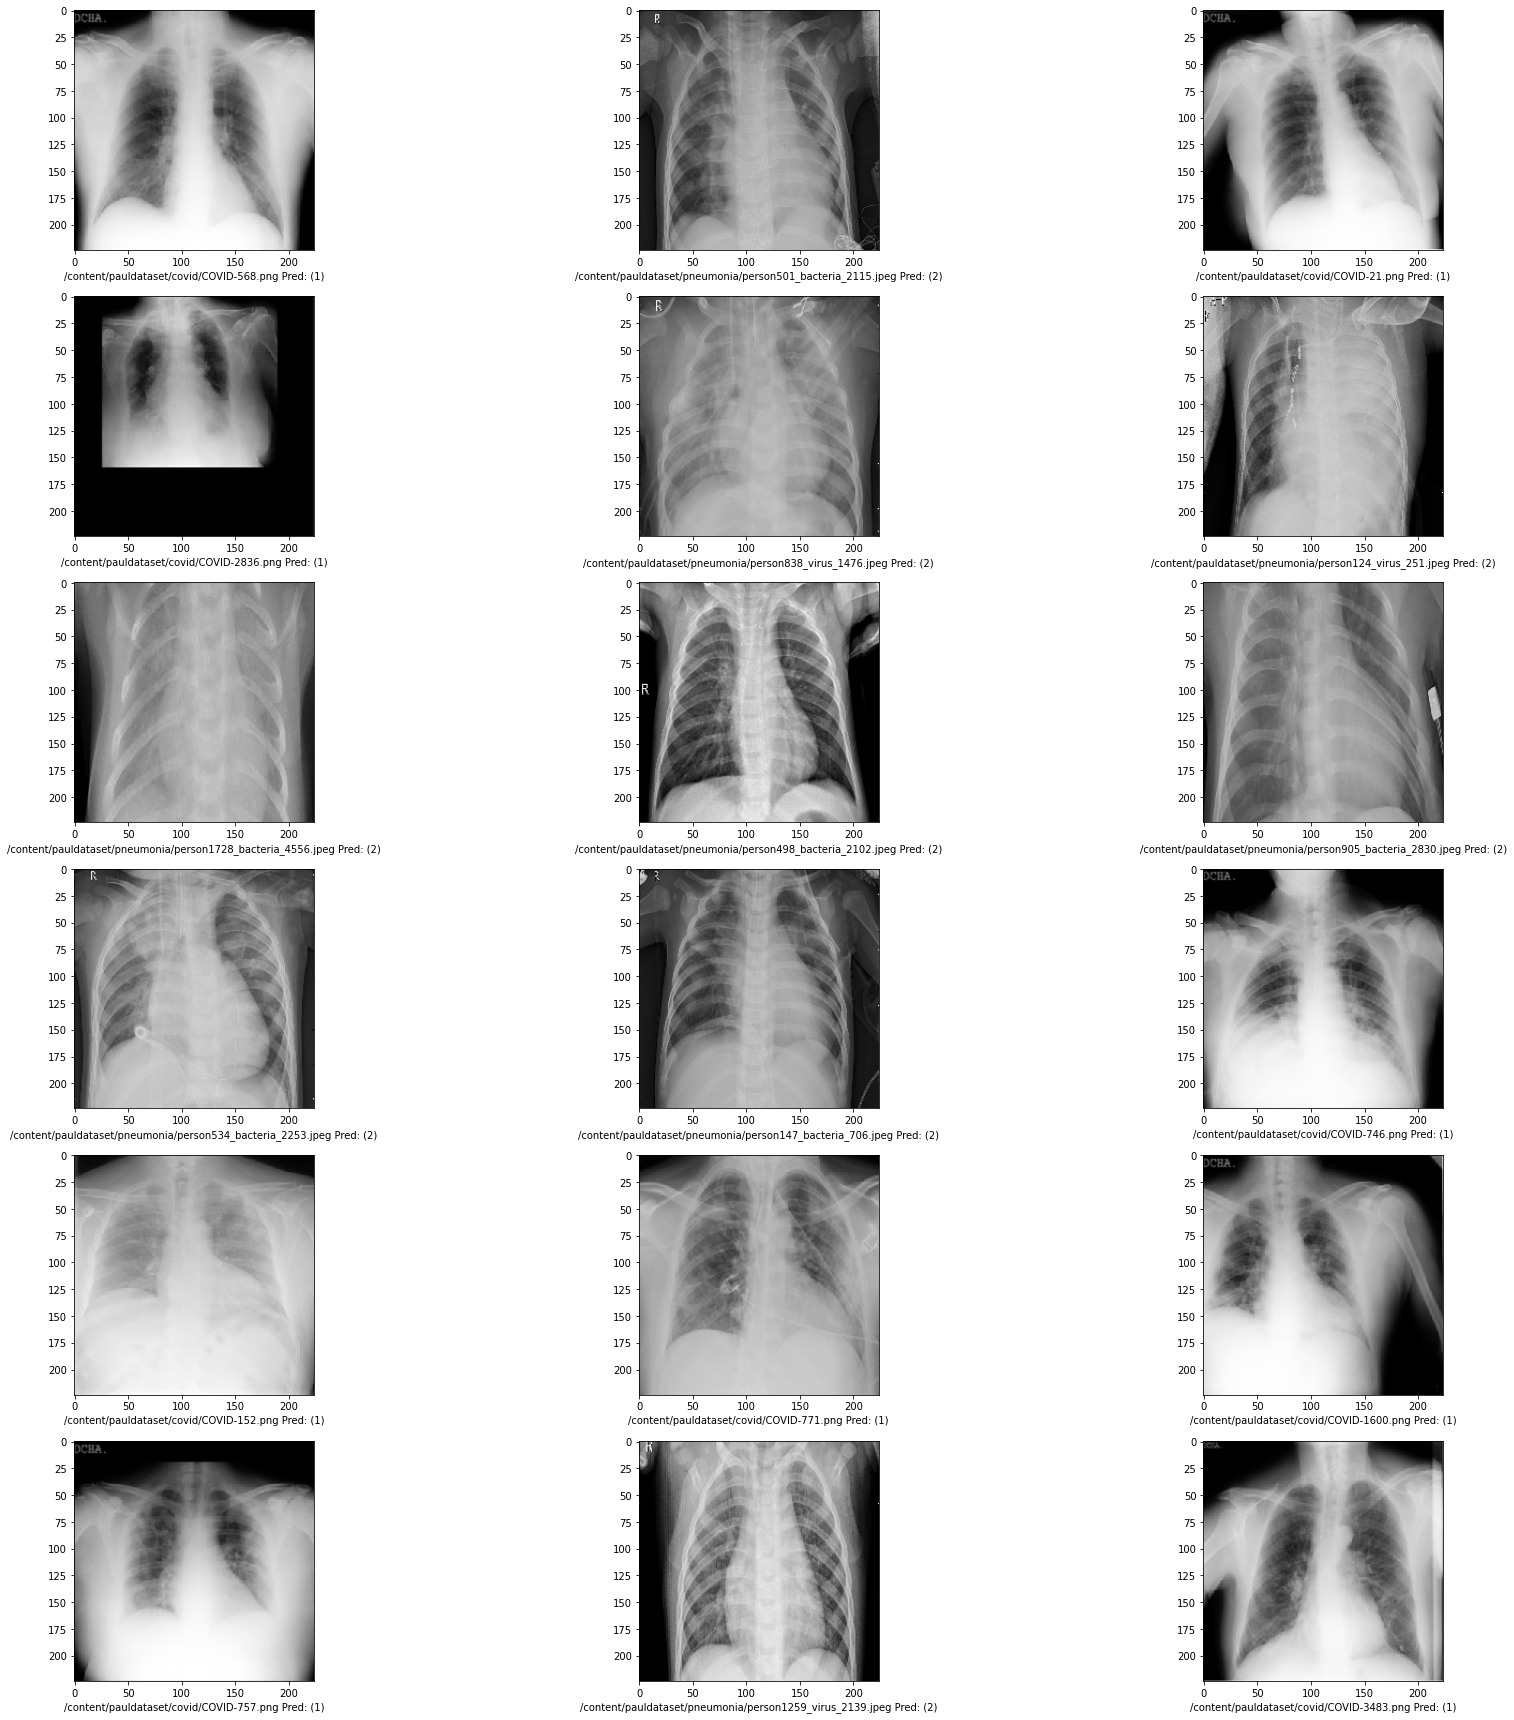

In [ ]:
plt.figure(figsize=(24, 24))

for index, row in sample_test.iterrows():
    
    filename = row['filename']
    category = row['category']
    
    img = load_img (filename, target_size=IMAGE_SIZE)
    
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + ' Pred: (' + "{}".format(category) + ')' )
    # break;
    
plt.tight_layout()
plt.show()

# Calculate Model Accuracy

In [ ]:
sample_test = test_df
correctPredictions = 0

correctNormalPred = 0
correctCovidPred = 0
correctPneuPred = 0

totalNormalPred = 0
totalCovidPred = 0
totalPneuPred = 0

for index, row in sample_test.iterrows():
    
    filename = row['filename']
    prediction = row['category']
    
    img = load_img( filename, target_size=IMAGE_SIZE)
    
    if 'normal' in filename:
        
        if prediction == 0:
            correctPredictions += 1
            correctNormalPred += 1
            
        totalNormalPred += 1
    
    if 'covid' in filename:
        if prediction == 1: 
            correctPredictions += 1
            correctCovidPred += 1
            
        totalCovidPred += 1
    
    if 'pneumonia' in filename:
        
        if prediction == 2: 
            correctPredictions += 1
            correctPneuPred += 1
            
        totalPneuPred += 1

In [ ]:
print('Model Accuracy:', "{:.2%}".format(correctPredictions / test_df.shape[0]))
print('Correct Predictions:', correctPredictions, 'Total Predictions:', test_df.shape[0])

print('\nNormal Predictions:', correctNormalPred, 'Accuracy', "{:.2%}".format(correctNormalPred /  totalNormalPred))
print('COVID-19 Predictions:', correctCovidPred, 'Accuracy', "{:.2%}".format(correctCovidPred /  totalCovidPred))
print('Viral Pneumonia Predictions:', correctPneuPred, 'Accuracy', "{:.2%}".format(correctPneuPred / totalPneuPred))

Model Accuracy: 98.05%
Correct Predictions: 1858 Total Predictions: 1895

Normal Predictions: 304 Accuracy 95.90%
COVID-19 Predictions: 722 Accuracy 99.86%
Viral Pneumonia Predictions: 832 Accuracy 97.31%


In [ ]:
actual = []
pred = []

for row in test_df.iterrows():
    
    filename = row[1][0]
    
    if 'normal' in filename: actual.append(0)
    if 'covid' in filename: actual.append(1)
    if 'pneumonia' in filename: actual.append(2)
        
    pred.append(row[1][1])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(actual, pred))  

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       317
           1       1.00      1.00      1.00       723
           2       0.98      0.97      0.98       855

    accuracy                           0.98      1895
   macro avg       0.97      0.98      0.97      1895
weighted avg       0.98      0.98      0.98      1895



In [ ]:
confusion_matrix(actual, pred)

array([[304,   0,  13],
       [  0, 722,   1],
       [ 21,   2, 832]])

# Predict single

In [ ]:
batch_size = 1
nb_samples = 1

In [ ]:
test_file = ["/content/pauldataset/normal/NORMAL2-IM-1203-0001.jpeg"]
df_file = pd.DataFrame({
    'filename': test_file
})

In [ ]:
df_file

,filename
0,/content/pauldataset/normal/NORMAL2-IM-1203-0001.jpeg


In [ ]:
test_single_gen = ImageDataGenerator(rescale = 1./127.5).flow_from_dataframe(
    df_file, 
    x_col = 'filename',
    y_col = None,
    class_mode = None,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    shuffle = False
)

Found 1 validated image filenames.


In [ ]:
predict = loaded_model.predict(test_single_gen, steps = np.ceil(nb_samples/batch_size))

In [ ]:
df_file['category'] = np.argmax(predict, axis=-1)

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
df_file['category'] = df_file['category'].replace(label_map)

In [ ]:
# df_file['category'] = df_file['category'].replace({'Normal': 0, 'Covid': 1, 'Pneumonia': 2})

In [ ]:
df_file

,filename,category
0,/content/pauldataset/normal/NORMAL2-IM-1203-0001.jpeg,Normal
